# Interpreting the Models

While we may be able to achieve a relatively good accuracy score for our images, interpreting the results is crucial for both patients and physicians. Patients deserve to know why and how a diagnosis was obtained, and physicians should be in a position to discuss these results. Here, we investigate possible methods of interpreting the model. 

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras.models import load_model
import tensorflow as tf
#import cv2
import pandas as pd
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import activations
from keras import utils

import keras

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

import shap

## Saliency Maps

At least to our own untrained eyes, it is somewhat difficult to distinguish the five classes in many of the training images, but we can identify areas of interest that might be important for a classification. This would likely be different for a trained radiologist -- perhaps the saliency map can help us see what a radiologist might be trained to look for. The question is whether our model is using the same pixels as the ones we (or a radiologist) would to classify an image as a particular class.

In [0]:
model_0 = load_model('models/resnet50_model_0_best_weights.h5')
model_0.layers[-1].activation = activations.linear
model_0 = utils.apply_modifications(model_0)

In [0]:
model_2 = load_model('models/resnet50_model_2_best_weights.h5')
model_2.layers[-1].activation = activations.linear
model_2 = utils.apply_modifications(model_2)

In [0]:
model_5 = load_model('models/resnet50_model_5_best_weights.h5')
model_5.layers[-1].activation = activations.linear
model_5 = utils.apply_modifications(model_5)

In order to produce a saliency map most conducive to interpretation, we find the examples with the highest prediction probability for each model. We do so by having the model predict on 5000 images from the data generator, and then taking the highest probability images from each class, ensuring that the model predicts these examples correctly.

We have some suspicion our test data may be from a different distribution, so we experiment with interpreting images from the training set.

**NOTE: The code below is an example what we used to produce the images. The actual images we chose are reported below this second to avoid running these cells unnecessarily.** 

In [0]:
#If it's class (key), should predict (value)
classes_to_pred_dict = {0:{0:0,1:1,2:2,3:3,4:4},
                        2:{0:None,1:0,2:1,3:3,4:3},
                        5:{0: None, 1: None, 2: 0, 3: None, 4: 1}}

In [0]:
def max_probabilities_each_class(probabilities, classes, data_df, c_to_p_dict):
    class_indices_dict = {}
    for i,p in enumerate(probabilities):
        c = data_df.iloc[i]['class']
        y_true = c_to_p_dict[c]
        if y_true is not None:
            if y_true not in class_indices_dict:
                class_indices_dict[y_true] = (i,p[y_true])
            else:
                _, max_p = class_indices_dict[y_true]
                if p[y_true] > max_p:
                    class_indices_dict[y_true] = (i,p[y_true])
    return class_indices_dict

Resulting images for saliency mapping

In [0]:
saliency_imgs = {
0: {
    0: {'p_max' : 1.0, 'filename' : 'c1.png'},
    1: {'p_max' : 0.952381, 'filename' : 'c55588.png'},
    2: {'p_max' : 0.999957, 'filename' : 'c51917.png'},
    3: {'p_max' : 0.992362, 'filename' : 'c51993.png'},
    4: {'p_max' : 0.999418, 'filename' : 'c45083.png'}},
2: {
    0: {'p_max' : 0.999989, 'filename' : 'c26275.png'},
    1: {'p_max' : 0.999996, 'filename' : 'c22152.png'},
    2: {'p_max' : 1.0, 'filename' : 'c26083.png'},
    3: {'p_max' : 1.0, 'filename' : 'c27278.png'}},
5: {
    0: {'p_max' : 1.0, 'filename' : 'c1367.png'},
    1: {'p_max' : 1.0, 'filename' : 'c26238.png'}}}

Saliency maps work by computing the gradient of the output category with respect to small changes in the input image. This method allows us to visualize which pixels contribute most to the classification, in that changing an "important" pixel or group of pixels would change the classification.

Below, we investigate three different methods of producing a saliency map. Normal/vanilla, guided, and relu/rectified. Guided saliency restricts backpropagation to only positive gradients for positive activations, while relu saliency restricts to only positive gradient information.

In [0]:
def display_saliency_maps(model, classes_dict):
    
    for class_idx in classes_dict.keys():    
        f, ax = plt.subplots(1, 4)
        im = plt.imread('data/train_images/' + classes_dict[class_idx]['filename'])
        im = np.stack((im.reshape((299,299)),)*3, axis=-1)
        ax[0].imshow(im)
        layer_idx = -1
        for i, modifier in enumerate([None, 'guided', 'relu']):
            grads = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
                                       seed_input=im, backprop_modifier=modifier)
            if modifier is None:
                modifier = 'vanilla'
            ax[i+1].set_title(modifier)    
            ax[i+1].imshow(grads, cmap='jet')
        [a.axis('off') for a in ax]

### Model 0: Raw Pre-Processed DDSM Dataset (Classes 0 to 4)

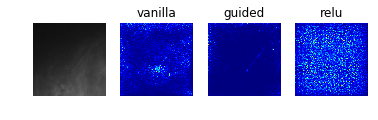

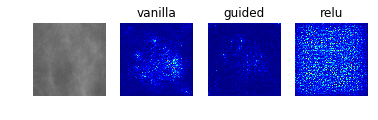

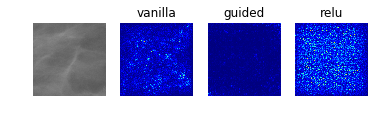

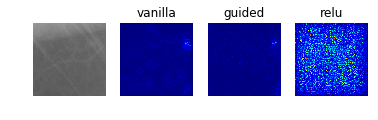

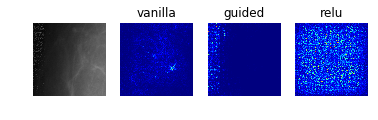

In [0]:
display_saliency_maps(model_0, saliency_imgs[0])

Especially noteworthy is the fact that model 0 identifies a particular point near the center of the first image (corresponding to a case with no mass or calcification) as being a salient indicator of the normality of this case. It may be that this concentrated region of high-saliency in the "vanilla" saliency map indicates that it is because the model *did not* see a feature at this location (which is perhaps the average location for where the masses/calcifications are located in the training set images) that suggests the image corresponds to a normal case. This would seem to undermine our initial suspicion that the model was so successful at identifying normal cases because it was relying on some property of the image itself (e.g. the distribution of pixel intensities) rather than the absence of a suspicious abnormality.

### Model 2: Classification of Abnormalities (Classes 1 to 4)

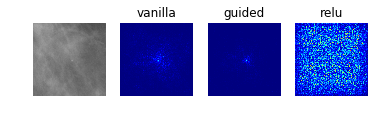

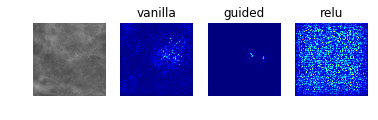

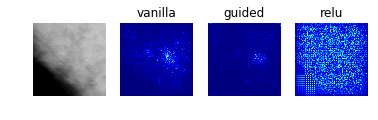

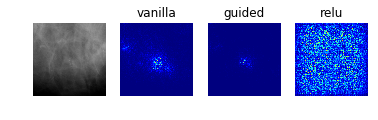

In [0]:
display_saliency_maps(model_2, saliency_imgs[2])

The model appears to have correctly identified the location of the abnormalities, though it is difficult for us to determine from these particular saliency maps (though perhaps would not be to a trained radiologist) what in particular about each abnormality caused the model to classify it among the four possible classes. We attempted to better understand what subportions of the abnormalities caused the classifier to differentiate among the "positive" classes by using Local Interpretable Model-Agnostic Explanations (LIME), as discussed below.

### Model 5: Benign vs Malignant Mass


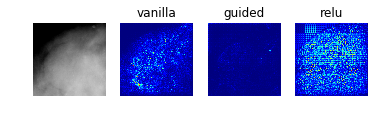

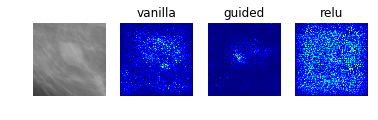

In [0]:
display_saliency_maps(model_5, saliency_imgs[5])

As with the results from model 2, these saliency maps make clear that model 5 has correctly identified the mass as the crucial feature in the image, though again it is not obvious what specific aspects of the mass led the classifier identify it as benign or malignant.

## Local Interpretable Model-Agnostic Explanations (LIME)

As a local surrogate model, LIME performs image segmentation to identify super-pixels in an single input image, then measures how the output of the model changes as super-pixels are included or omitted ("perturbing" the input). In this way, LIME clearly identifies which contiguous regions of the input contribute to the model's decision, and would therefore appear to be a valuable addition to the saliency maps, which did not offer clear a perspective into what features of the images the model used to identify among types of abnormalities. 

However, we were unable to extract meaningful results from LIME, as shown below. This was in part due to the fact that many of the classification decisions appeared to be made because of the absence of not-obviously-meaningful content in the images. Additionally, it is well-documented that LIME is highly sensitive to the choice of segmentation-algorithm parameters, which influence which super-pixels are identified.$^1$ 


    
[1] Molnar, Christoph. "Interpretable machine learning. A Guide for Making Black Box Models Explainable", 2019. https://christophm.github.io/interpretable-ml-book/.

### Model 2

In [0]:
model_2 = load_model('models_updated/resnet50_model_2_best_weights.h5')

m2_c1_img = cv2.imread('images/' + "c26275.png")
m2_c2_img = cv2.imread('images/' + "c22152.png")
m2_c3_img = cv2.imread('images/' + "c26083.png")
m2_c4_img = cv2.imread('images/' + "c27278.png")

**Class 1: Benign Calcification**

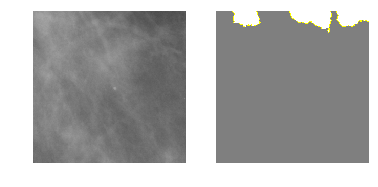

In [0]:
explanation1 = explainer.explain_instance(m2_c1_img, model_2.predict, top_labels=4, hide_color=0, num_samples=1000)
temp, mask = explanation1.get_image_and_mask(0, positive_only=False, num_features=5, hide_rest=True)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(m2_c1_img)
axes[1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
[ax.axis('off') for ax in axes];

**Class 2: Benign Mass**

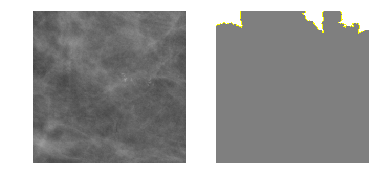

In [0]:
explanation2 = explainer.explain_instance(m2_c2_img, model_2.predict, top_labels=4, hide_color=0, num_samples=1000)
temp, mask = explanation2.get_image_and_mask(1, positive_only=False, num_features=5, hide_rest=True)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(m2_c2_img)
axes[1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
[ax.axis('off') for ax in axes];

**Class 3: Malignant Calcification**

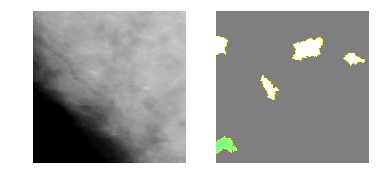

In [0]:
explanation3 = explainer.explain_instance(m2_c3_img, model_2.predict, top_labels=4, hide_color=0, num_samples=1000)
temp, mask = explanation3.get_image_and_mask(2, positive_only=False, num_features=5, hide_rest=True)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(m2_c3_img)
axes[1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
[ax.axis('off') for ax in axes];

**Class 4: Malignant Mass**

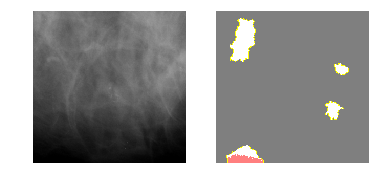

In [0]:
explanation4 = explainer.explain_instance(m2_c4_img, model_2.predict, top_labels=4, hide_color=0, num_samples=1000)
temp, mask = explanation4.get_image_and_mask(3, positive_only=False, num_features=5, hide_rest=True)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(m2_c4_img)
axes[1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
[ax.axis('off') for ax in axes];

### Model 5

In [0]:
model_5 = load_model('models_updated/resnet50_model_5_best_weights.h5')

m5_c0_img = cv2.imread('images/' + "c1367.png")
m5_c1_img = cv2.imread('images/' + "c26238.png")

**Class 0: Benign Mass**

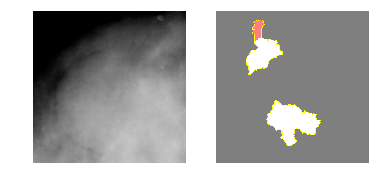

In [0]:
explanation0 = explainer.explain_instance(m5_c0_img, model_5.predict, top_labels=2, hide_color=0, num_samples=1000)
temp, mask = explanation0.get_image_and_mask(0, positive_only=False, num_features=5, hide_rest=True)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(m5_c0_img)
axes[1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
[ax.axis('off') for ax in axes];

**Class 1: Malignant Mass**

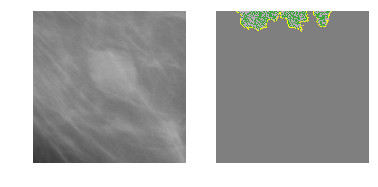

In [0]:
explanation1 = explainer.explain_instance(m5_c1_img, model_5.predict, top_labels=2, hide_color=0, num_samples=1000)
temp, mask = explanation1.get_image_and_mask(1, positive_only=False, num_features=5, hide_rest=True)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(m5_c1_img)
axes[1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
[ax.axis('off') for ax in axes];

## SHapley Additive exPlanations (SHAP)

We were unfortunately unable to exploit Shapley values as yet another alternative to the two previous interpretability metrics given resource constraints. With more time, we would have been interested in investigating Deep SHAP, which approximates SHAP values in order to reduce the algorithm's complexity, enabling it to be used for deep learning models.

In [0]:
train_df_model_2 = pd.read_csv('data/train_df_model_2.csv')

In [0]:
# select a set of background examples to take an expectation over
background_paths = np.random.choice(train_df_model_2['filename'], 50, replace=False)

In [0]:
background = [plt.imread('images/' + path)*(1./255) for path in background_paths]
background = [np.stack((im.reshape((299,299)),)*3, axis=-1) for im in background]
background = np.array(background)

In [0]:
# explain predictions of the model on four images
e = shap.DeepExplainer(model_2, background)

In [0]:
shap_values = e.shap_values(background[1:5])

# plot the feature attributions
shap.image_plot(shap_values, -background[1:5])

ResourceExhaustedError: ignored